# 4. Series de tiempo
Descripción : 
Pronosticar las ventas de un producto o de una categoría es un desafío recurrente
para cualquier ecommerce.
En este caso, el desafío va a ser pronosticar la cantidad de unidades diarias que van a
vender 3 categorías distintas de MELI.
El dataset “series.csv” tiene las ventas en unidades diarias de 3 categorías que
poseen un id único y su fecha de venta

-  predict 21 dias.


# Nota 
## Após diversas tentativas utilizado os algoritmo ARIMA e SARIMAX não fui capaz de chegar a um resultado razoável. 
Aparentemente, os algoritmos realizaram um "fit" razoavelmente justo com os dados de treino, mas quando utilizados para realizar "forcast" dos dados de teste e validação, os resultados ficaram claramente fora do esperado.
Assim, apesar de deixar este notebook aqui para que eu possa mais tarde compreender onde estou errando, peço que desconsiderem este notebook. 


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
dtseries = pd.read_csv('series.csv')

dtseries['DATE'] = pd.to_datetime(dtseries['DATE'])

dtseries['MONTH'] = dtseries.DATE.dt.month
dtseries['day'] = dtseries.DATE.dt.day
dtseries['MONTH-day'] =dtseries['MONTH'] +  dtseries['day'] /100


In [69]:

dtseries.groupby(['CATEGORY'])['CATEGORY'].count()


CATEGORY
CATEG-1    887
CATEG-2    879
CATEG-3    920
Name: CATEGORY, dtype: int64

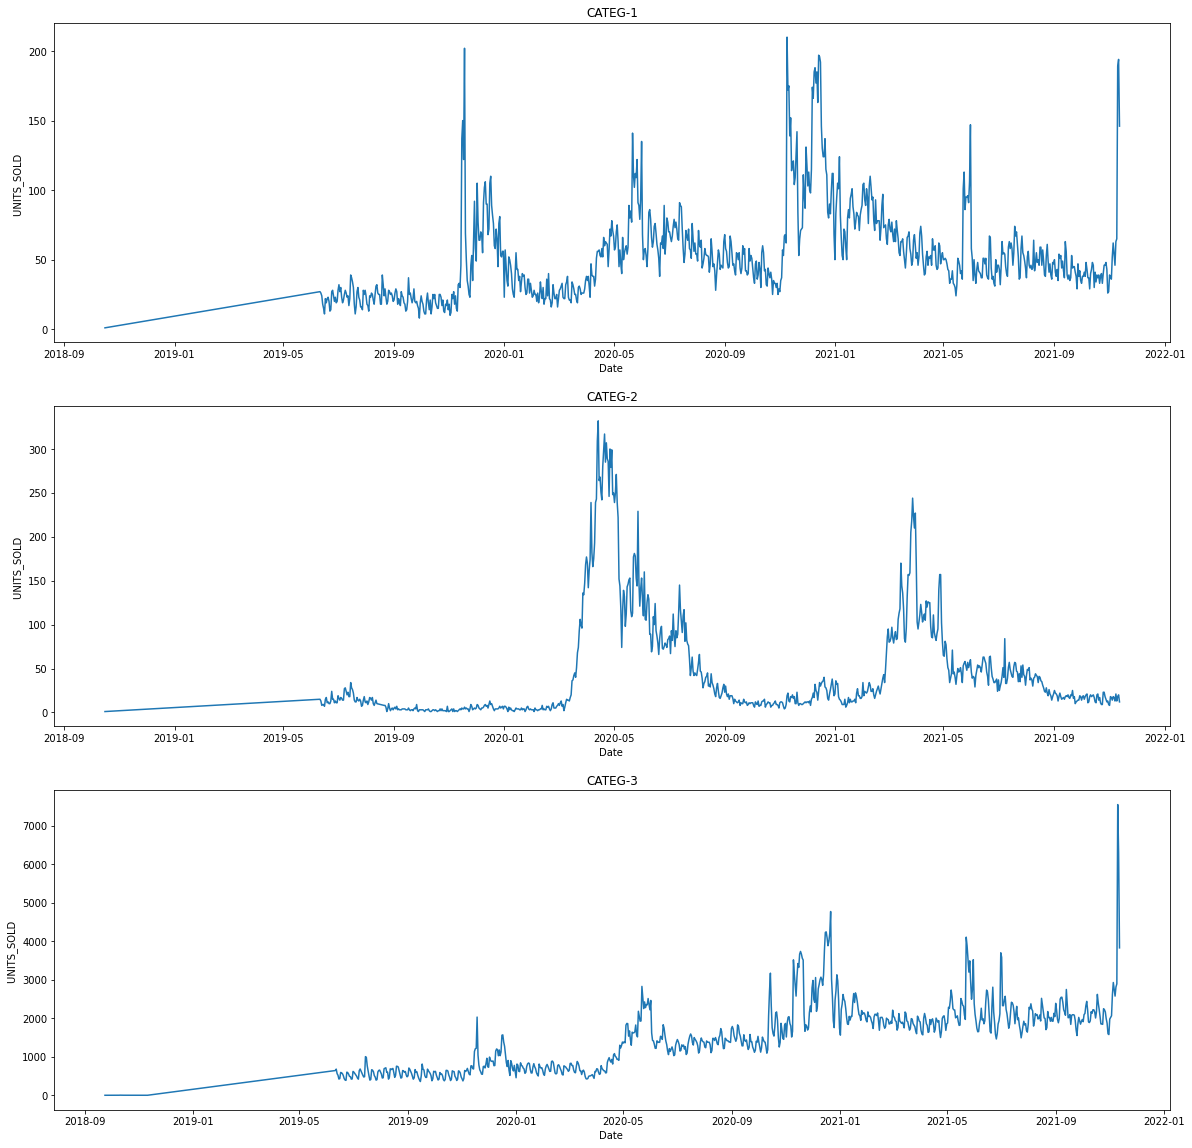

In [5]:
catagorias = list(dtseries['CATEGORY'].unique())
catagorias
dtseriescat  = dtseries[dtseries['CATEGORY'] ==catagorias[0]]
dtseriescat = dtseriescat.sort_values(by='DATE')
dtseriescat['DATE']
i =0


fig, ax = plt.subplots(3,  figsize=(20,20))
for catagoria in catagorias :
    dtseriescat  = dtseries[dtseries['CATEGORY'] ==catagoria]
    dtseriescat = dtseriescat.sort_values(by='DATE')
    ax[i].plot(dtseriescat['DATE'], dtseriescat['UNITS_SOLD'])

    ax[i].set(xlabel='Date ', ylabel='UNITS_SOLD ',
       title=catagoria )
    i= i +1
    
       
       

In [6]:
# check se o data set eh continuo
for catagoria in catagorias :
    dtseriescat  = dtseries[dtseries['CATEGORY'] ==catagoria]
    dtseriescat = dtseriescat.sort_values(by='DATE')
    times_gaps = (dtseriescat['DATE'] - dtseriescat['DATE'].shift(1)) /np.timedelta64(1, 'D')
    times_gaps =np.where(times_gaps.values > 1 )
    print("Catagory {} has the size of {} and the last position gap is  {} ".format(catagoria, dtseriescat.shape[0], times_gaps[0][-1] ) )
    

Catagory CATEG-1 has the size of 887 and the last position gap is  1 
Catagory CATEG-2 has the size of 879 and the last position gap is  131 
Catagory CATEG-3 has the size of 920 and the last position gap is  34 


###  Use auto_arima to get the best parameters 
     [ [(2, 0,1)  , (2,0,0,12)],
     [(1, 1, 1), (1, 1, 1, 12)] ,
     [(5, 4, 3), (1, 1, 1, 12)]]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
catindex = 2
testindex = 0
datasets , values, MONTHS, DAYS  =  getdatasetCat(catagorias[catindex])
dataset = datasets[testindex]
trainv = values[dataset[0]]
trainm = MONTHS[dataset[0]]
testev = values[dataset[1]]
testem = values[dataset[1]]

    
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(values, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

In [43]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

def testeSARIMAX_exog(catindex,testindex, order , seasonal_order ):
    datasets , values, MONTHS, DAYS  =  getdatasetCat(catagorias[catindex])
    dataset = datasets[testindex]
    trainv = values[dataset[0]]
    trainm = MONTHS[dataset[0]]
    testev = values[dataset[1]]
    testem = values[dataset[1]]

    model = sm.tsa.SARIMAX(trainv,  exog=trainm, order=order
                       ,seasonal_order=seasonal_order)

    model_fit = model.fit()

    #predict = model_fit.forecast(testesize , exog=testem)
    predict = model_fit.forecast(testesize , exog=testem)
    fittedvalues = model_fit.fittedvalues

    mape = np.mean(np.abs(predict - teste)/np.abs(teste))  # MAPE
    return mape , trainv, testev , predict, fittedvalues

orders = [ [(2, 0,1)  , (2,0,0,12)],
           [(1, 1, 1), (1, 1, 1, 12)] ,
           [(5, 4, 3), (1, 1, 1, 12)]]

           
results = []
resultsp = []
for order in orders:
    for indicecat in [0,1,2]:
        for indextes in range(splitSize):
            try:
                mape , trainv, testev , predict, fittedvalues = testeSARIMAX_exog(indicecat, indextes, order[0], order[1] )    
                results.append([catagorias[indicecat],  mape , str(order)  ])
                resultsp.append([indicecat, predict , fittedvalues])
            except:
                print("An exception occurred", indicecat, indextes ,order) 
    




An exception occurred 0 1 [(5, 4, 3), (1, 1, 1, 12)]


In [44]:
df = pd.DataFrame (results, columns = ['cate','map', 'order' ])
ordersp = list(df['order'].unique())
resumoteste =[]

for cat in catagorias:
    dfcat = df[df['cate'] == cat]
    for order in ordersp:
        testerro = dfcat[dfcat['order'] == order].iloc[0:3]['map'].mean()
        validaderro = dfcat[dfcat['order'] == order].iloc[3:6]['map'].mean()
        desvio= dfcat[dfcat['order'] == order]['map'].describe()['std']
        resumoteste.append([cat,order, testerro , validaderro, desvio ])

dfresumo = pd.DataFrame (resumoteste, columns = ['cat','order', 'test error MAP', 'validation error MAP', 'desvio' ])
dfresumo

,cat,order,test error MAP,validation error MAP,desvio
0,CATEG-1,"[(2, 0, 1), (2, 0, 0, 12)]",0.749568,0.781100,0.037813
1,CATEG-1,"[(1, 1, 1), (1, 1, 1, 12)]",0.757983,0.788467,0.035040
2,CATEG-1,"[(5, 4, 3), (1, 1, 1, 12)]",0.854436,0.905310,0.032528
3,CATEG-2,"[(2, 0, 1), (2, 0, 0, 12)]",0.959980,0.981802,0.012397
4,CATEG-2,"[(1, 1, 1), (1, 1, 1, 12)]",0.954563,0.979944,0.014408
5,CATEG-2,"[(5, 4, 3), (1, 1, 1, 12)]",1.028889,0.993803,0.037461
6,CATEG-3,"[(2, 0, 1), (2, 0, 0, 12)]",50.205187,73.811692,17.413326
7,CATEG-3,"[(1, 1, 1), (1, 1, 1, 12)]",65.105700,72.703254,11.688516
8,CATEG-3,"[(5, 4, 3), (1, 1, 1, 12)]",26.017153,33.416064,9.154587


# Teste Arima 

In [71]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

def testeARIMA(catindex,testindex, order , seasonal_order ):
    datasets , values, MONTHS, DAYS  =  getdatasetCat(catagorias[catindex])
    dataset = datasets[testindex]
    trainv = values[dataset[0]]
    trainm = MONTHS[dataset[0]]
    testev = values[dataset[1]]
    testem = values[dataset[1]]
    
    model = ARIMA(trainv, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    predict = model_fit.forecast(testesize)  
    fittedvalues = model_fit.fittedvalues

    mape = np.mean(np.abs(predict - teste)/np.abs(teste))  # MAPE
    return mape , trainv, testev , predict, fittedvalues
    
orders = [ [(2, 0,1)  , (2,0,0,12)],
           [(3, 0,1)  , (2,1,0,12)] ]

results = []
resultsp = []
for order in orders:
    for indicecat in [0,1,2]:
        for indextes in range(splitSize):
            try:
                mape , trainv, testev , predict, fittedvalues = testeARIMA(indicecat, indextes, order[0], order[1] )    
                results.append([catagorias[indicecat],  mape , str(order)  ])
                resultsp.append([indicecat, predict , fittedvalues])
            except:
                print("An exception occurred", indicecat, indextes ,order) 

                
df = pd.DataFrame (results, columns = ['cate','map', 'order' ])
ordersp = list(df['order'].unique())
resumoteste =[]

for cat in catagorias:
    dfcat = df[df['cate'] == cat]
    for order in ordersp:
        testerro = dfcat[dfcat['order'] == order].iloc[0:3]['map'].mean()
        validaderro = dfcat[dfcat['order'] == order].iloc[3:6]['map'].mean()
        desvio= dfcat[dfcat['order'] == order]['map'].describe()['std']
        resumoteste.append([cat,order, testerro , validaderro, desvio ])

dfresumo = pd.DataFrame (resumoteste, columns = ['cat','order', 'test error MAP', 'validation error MAP', 'desvio' ])
dfresumo


,cat,order,test error MAP,validation error MAP,desvio
0,CATEG-1,"[(2, 0, 1), (2, 0, 0, 12)]",0.920196,0.931055,0.007722
1,CATEG-1,"[(3, 0, 1), (2, 1, 0, 12)]",0.922067,0.933404,0.008409
2,CATEG-2,"[(2, 0, 1), (2, 0, 0, 12)]",0.936195,0.966953,0.018003
3,CATEG-2,"[(3, 0, 1), (2, 1, 0, 12)]",0.940091,0.977539,0.021037
4,CATEG-3,"[(2, 0, 1), (2, 0, 0, 12)]",1.685290,1.864676,0.175599
5,CATEG-3,"[(3, 0, 1), (2, 1, 0, 12)]",2.234086,2.281773,0.110318


In [72]:

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

def testeARIMA(catindex,testindex, order , seasonal_order ):
    datasets , values, MONTHS, DAYS  =  getdatasetCat(catagorias[catindex])
    dataset = datasets[testindex]
    trainv = values[dataset[0]]
    trainm = MONTHS[dataset[0]]
    testev = values[dataset[1]]
    testem = values[dataset[1]]
    
    model = ARIMA(trainv, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    predict = model_fit.forecast(testesize)  
    fittedvalues = model_fit.fittedvalues

    mape = np.mean(np.abs(predict - teste)/np.abs(teste))  # MAPE
    return mape , trainv, testev , predict, fittedvalues
    
orders = [ [(2, 0,1)  , (2,0,0,12)],
           [(3, 0,1)  , (2,1,0,12)] ]

results = []
resultsp = []
for order in orders:
    for indicecat in [0,1,2]:
        for indextes in range(splitSize):
            try:
                mape , trainv, testev , predict, fittedvalues = testeARIMA(indicecat, indextes, order[0], order[1] )    
                results.append([catagorias[indicecat],  mape , str(order)  ])
                resultsp.append([indicecat, predict , fittedvalues])
            except:
                print("An exception occurred", indicecat, indextes ,order) 

                
df = pd.DataFrame (results, columns = ['cate','map', 'order' ])
ordersp = list(df['order'].unique())
resumoteste =[]

for cat in catagorias:
    dfcat = df[df['cate'] == cat]
    for order in ordersp:
        testerro = dfcat[dfcat['order'] == order].iloc[0:3]['map'].mean()
        validaderro = dfcat[dfcat['order'] == order].iloc[3:6]['map'].mean()
        desvio= dfcat[dfcat['order'] == order]['map'].describe()['std']
        resumoteste.append([cat,order, testerro , validaderro, desvio ])

dfresumo = pd.DataFrame (resumoteste, columns = ['cat','order', 'test error MAP', 'validation error MAP', 'desvio' ])
dfresumo


,cat,order,test error MAP,validation error MAP,desvio
0,CATEG-1,"[(2, 0, 1), (2, 0, 0, 12)]",0.920196,0.931055,0.007722
1,CATEG-1,"[(3, 0, 1), (2, 1, 0, 12)]",0.922067,0.933404,0.008409
2,CATEG-2,"[(2, 0, 1), (2, 0, 0, 12)]",0.936195,0.966953,0.018003
3,CATEG-2,"[(3, 0, 1), (2, 1, 0, 12)]",0.940091,0.977539,0.021037
4,CATEG-3,"[(2, 0, 1), (2, 0, 0, 12)]",1.685290,1.864676,0.175599
5,CATEG-3,"[(3, 0, 1), (2, 1, 0, 12)]",2.234086,2.281773,0.110318


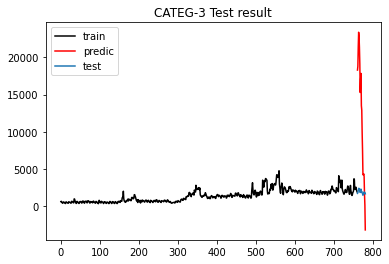

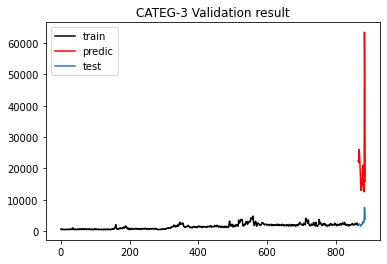

,cat,order,test error MAP,validation error MAP,desvio
0,CATEG-1,"[(2, 0, 1), (2, 0, 0, 12)]",0.920196,0.931055,0.007722
1,CATEG-1,"[(3, 0, 1), (2, 1, 0, 12)]",0.922067,0.933404,0.008409
2,CATEG-2,"[(2, 0, 1), (2, 0, 0, 12)]",0.936195,0.966953,0.018003
3,CATEG-2,"[(3, 0, 1), (2, 1, 0, 12)]",0.940091,0.977539,0.021037
4,CATEG-3,"[(2, 0, 1), (2, 0, 0, 12)]",1.685290,1.864676,0.175599
5,CATEG-3,"[(3, 0, 1), (2, 1, 0, 12)]",2.234086,2.281773,0.110318


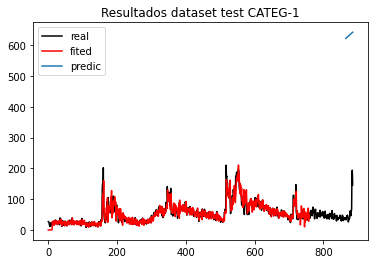

In [68]:
 
order = orders[1]
mape , trainv, testev , predict, fittedvalues  = testeARIMA(0, 0, order[0], order[1] )    

printresultsH(values, fittedvalues, predict, 'Resultados dataset test CATEG-1' )               


In [ ]:

    
order = orders[0]
mape , trainv, testev , predict, fittedvalues  = testeSARIMAX_exog(0, 0, order[0], order[1] )    

                
printresults(trainv, testev, predict, "CATEG-1 Test result")

mape , trainv, testev , predict = testeSARIMAX_exog(0, 5, order[0], order[1] )    
printresults(trainv, testev, predict, "CATEG-1 Validation result")

indicecat, predict , fittedvalues    
datasets , values, MONTHS, DAYS  =  getdatasetCat(catagorias[catindex])
printresultsH(values, resultsp[0][2], resultsp[0][1], 'Resultados dataset test CATEG-1' )

catindex = 0 ARIMA(2,0,1)(2,1,0)[12]
catindex = 1 ARIMA(2,0,1)(2,1,0)[12]
catindex = 1 ARIMA(3,0,1)(2,1,0)

In [232]:

values[dataset[1]]
values[dataset[1]]


array([724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735])

(array([39, 33, 38, 40, 33, 40, 46, 46, 48, 43, 26, 27]),
 array([ 39,  37,  36,  52,  62,  54,  46,  63,  65, 189, 194, 146]))

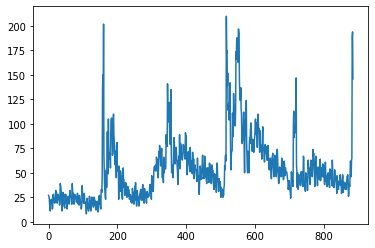

In [241]:
# 2 set of data: [teste ] [Validation ]
def printresultsH(values, fit, predic,Title):
    indice = list(range(len(values)))
    indicef = list(range(len(fit)))
    ini = len(values) - len(predic)
    indicepre = list(range(ini, ini + len(predic)))
    
    plt.plot(indice, values, color = "black", label='real')
    plt.plot(indicef, fit, color = "red",label='fited')
    plt.plot(indicepre, teste, label='predic')
    plt.title(Title)
    plt.legend()
    plt.show()
    
dtseriescat  = getdatasetCat(catagorias[0])

values = dtseriescat0['UNITS_SOLD'].values
seriesindex=  tscv.split(values)
datasets = [] 
for train_index, test_index in seriesindex:
    datasets.append([values[train_index],values[test_index ]])






plt.plot(values)
datasets[0][1], datasets[1][1]


In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
order = orders[1]
mape , trainv, testev , predict = testeSARIMAX_exog(2, 0, order[0], order[1] )    
printresults(trainv, testev, predict, "CATEG-3 Test result")

mape , trainv, testev , predict = testeSARIMAX_exog(2, 5, order[0], order[1] )    
printresults(trainv, testev, predict, "CATEG-3 Validation result")
